# Portfolio-Exam Part I - Sentiment Analysis

* Social Media Analytics - MADS-SMA
* Valentin Werger

The aim of this project in the realm of sentiment analysis is to try and build a pipeline for a comprehensive performance comparison between different approaches and models. The analysis is carried out on a dataset of approximately 3000 yelp reviews for locations in Hamburg, in Englisch language. The target will be to predict a rating provided in form of stars, from the worst rating of 1 star up to 5 stars. In such a scenario a valid approach would also be to formulate the predictive problem as a regression task, that way the inherent ordering of the target would be respected. However, as previous experimenmts by other people have shown, a regression type task does not necessarily work better in such a scenario than a classification task. Therefore the general task for this project will be a multiclass prediction of five possible star ratings.

The experiments will include a baseline to compare, rule based approaches at giving a sentiment rating, different preprocessing and feature engineering techniques, a range of Machine Learning classifiers, hyperparameter optimization of those models and the processing steps as well as evaluating the performance of finetuned pretrained natural language transformer models.

### Loading packages

In [1]:
# Loading base and Sentiment related packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.downloader

In [2]:
# Loading required ML packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [3]:
import torch

### Exploring the data

In [4]:
# Read Hamburg Yelp reviews
yelp = pd.read_csv("yelp_reviews_hamburg_en.csv", parse_dates=["date"], dtype={"stars":"int64"})
# Subtract one from stars because some models (XGBoost, Transfomers) expects labels to be starting from 0
yelp["stars"] = yelp.stars - 1

In [5]:
# Overview of the data
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     3025 non-null   object        
 1   stars   3025 non-null   int64         
 2   text    3025 non-null   object        
 3   date    3025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 94.7+ KB


In [6]:
# Show the top 5 rows
yelp.head(5)

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,4,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,3,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,3,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,2,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,3,I love Campus Suite franchise. after the Balza...,2010-01-15


The dataframe includes a column for the url of the location, the target in form of stars, the review text and a data variable.

In [7]:
# Extract name of the location from url
yelp["name"] = yelp.apply(lambda row: re.sub("https://www.yelp.com/biz/", "", row["url"]), axis=1)
yelp = yelp.drop(columns="url")

<AxesSubplot:ylabel='Count'>

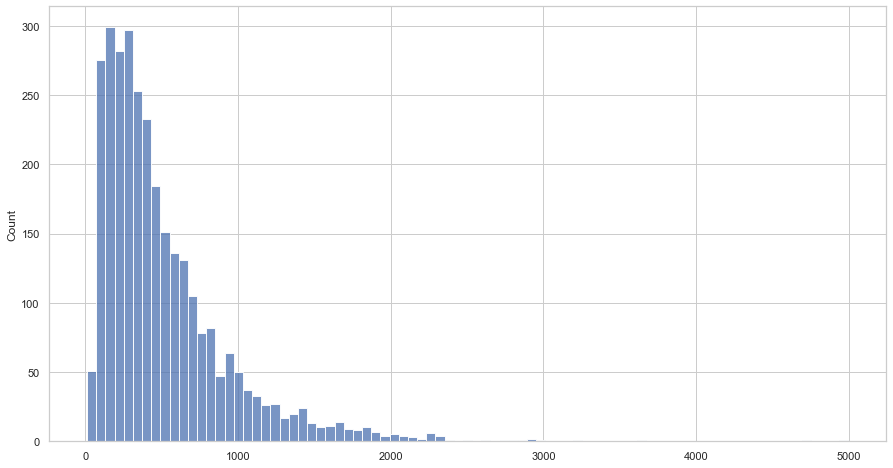

In [8]:
# Inspect length of review text
text_length_distribution = np.array([len(text) for text in yelp.text])

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

Some reviews are quite long which could become a problem for the transformer models, since they can only handle a maximum amount of input tokens. There are several possible techniques to deal with this, which will be explained later at the transformer part.

<AxesSubplot:xlabel='stars', ylabel='count'>

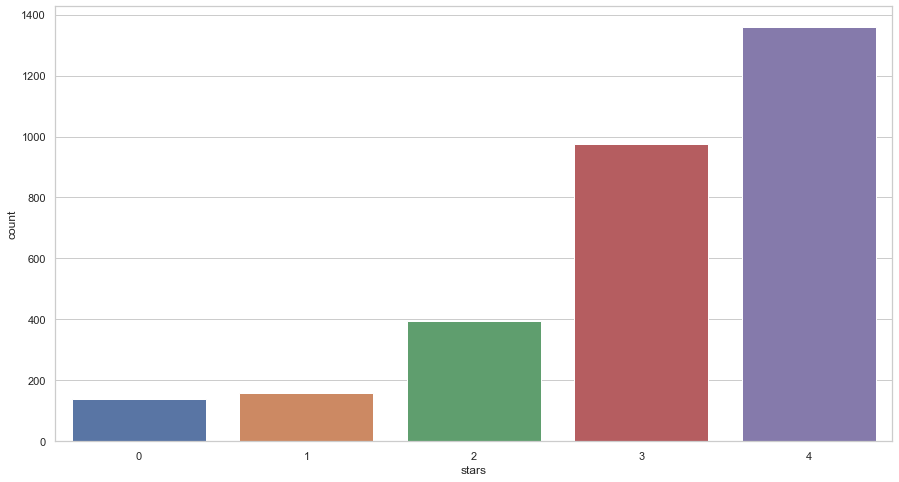

In [9]:
# Check distribution of ratings
sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.countplot(data = yelp, x = "stars")

The classes of the target data, so the stars given out by Yelp reviewers, are quite unbalanced. Only very few people have given a bad rating with 1 or 2 stars (0 and 1 in this graphic because 1 was subtracted from the column). At the same time the overwhelming majority of customers gave 4 or 5 star ratings to the places they visited. Depending on how important it is to correctly classify the different classes this could become a problem. Because there are so much more good reviews most algorithms will automatically adjust more on these samples, if the loss function does not correct for this imbalance, simply because the samples make up a higher percentage of the total loss. As a result a model typically becomes better at classifying the majority classes over the minority classes, in our case bad reviews. Because standard accuracy only looks at total accuracy this could then give a wrong impression of the models performance, if one is also interested in correct classifications of the smaller classes.

With this data this could exactly be the case. Business owners could be predemoninantly interested in identifying cases of negative reviews or remarks towards their business and then find the reasons for that or shut them down alltogether (which is of course ethically questionable). Therefore I will consider this problem in the following machine learning experiments in different ways.

* Several performance metrics that deal with the classes in various ways will be computed throughout beyond standard accuracy
* A possible Preprocessing Step will be added in the pipeline that applies oversampling through the use of Synthetic Minority Oversampling Technique (SMOTE). This adds artificial samples for the bad reviews so they are considered more during training. Whether this technique is applied will be considered a hyperparameter
* After hyperparameter optimization the best model according to average balanced accuracy instead of standard accuracy will be selected

In [10]:
# Load potential sets of word vectors
#list(gensim.downloader.info()['models'].keys())
potential_wv = {}
print("Downloading glove-wiki-gigaword-50")
potential_wv["wv_glove_wiki"] = gensim.downloader.load('glove-wiki-gigaword-300')
print("Downloading glove-twitter-50")
potential_wv["wv_glove_twitter"] = gensim.downloader.load('glove-twitter-200')
print("Downloading word2vec-google-news-300")
potential_wv["wv_word2vec"] = gensim.downloader.load('word2vec-google-news-300')

In the next part three helper classes for preprocessing the data are configured, to be used as part of the sklearn Pipeline. The reason to create such helper classes is that I want the feature engineering step of the text data to be part of the Machine Learning pipeline to conveniently compare the different possibilities and see how they influence the model performance. Besides that there is the problem of potential data leakage if we just transform the data one time through embeddings or word counts before repeatedly splitting into train and test sets for evaluation. In the case of text data this could also mean cheating the out of vocabulary problem that could arise in a real use of the model with new reviews. Including this step in the pipeline ensures that the same samples are used to train both the transformers and predictios. Additionally such a pipeline is convenient in that you only have to call fit and predict once on the data to fit a whole sequence of estimators as well as allowing parameter optimization for all estimators at once.

In this case I have set up the following parameters for the feature engineering part of the pipeline:

* WordCount/Tfidf
    * min_df (minimum document frequency)
        * 1
        * 2
        * 3
    * ngram_range (only use unigrams or unigrams and bigrams)
        * (1,1)
        * (1,2)
* Word Embeddings
    * wv (set of word vectors to use)
        * wv_glove_wiki
        * wv_glove_twitter
        * wv_word2vec

However recalculating the word embeddings every time the model is fit, that means also on every cross validation step, seemed to have an intense computational effect making it unfeasible. Fewer runs with actual model parameters could be made. Therefore I decided to write the helper classes to still use both methods in the pipeline, while at the same time only producing the embeddings once in the beginning and then transfer them as a data parameter to the helper. The trick to make it work also for the other two methods was to specify the X on which the pipeline is actually fitted merely as the index of the data. This index then gets divided in cross validation and the preprocessing helpers forward the actual data indexed by whatever index they are given by the pipeline.

### Defining functions

In [11]:
# Define Helper classes for sklearn outside of the main class to not break parallelization
class WordEmbeddingHelper(TransformerMixin, BaseEstimator):

    def __init__(self, data, wv):
        self.data = data
        self.wv = wv

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.data[X]

class WordCountTransformerHelper(TransformerMixin, BaseEstimator):

    def __init__(self, data, input, min_df=1, ngram_range=(1,1)):
        self.data = data
        self.input = input
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.transformer = CountVectorizer(min_df=self.min_df, ngram_range=self.ngram_range)

    def fit(self, X, y=None):
        self.transformer.fit(self.data[self.input][X])
        return self

    def transform(self, X):
        return self.transformer.transform(self.data[self.input][X])

class TfidfTransformerHelper(TransformerMixin, BaseEstimator):

    def __init__(self, data, input, min_df=1, ngram_range=(1,1)):
        self.data = data
        self.input = input
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.transformer = TfidfVectorizer(min_df=self.min_df, ngram_range=self.ngram_range)

    def fit(self, X, y=None):
        self.transformer.fit(self.data[self.input][X])
        return self

    def transform(self, X):
        return self.transformer.transform(self.data[self.input][X])

In [12]:
if torch.cuda.is_available():
    xgb_tree_method = "gpu_hist"
else:
    xgb_tree_method = "hist"

In [13]:
# Sentiment Analyser class
class SentimentAnalyser():

    def __init__(self, data, target, input, normalize = True, use_stop_words = True):
        self.data = data
        self.target = target
        self.input = input
        self.target_distribution = self.data[self.target].value_counts(normalize=True)

        # Normalize the review texts
        if normalize:
            self.data["text_normalized"] = self.normalize(use_stop_words)
            self.input = "text_normalized"

        # Initialize container for experiment results
        self.experiment_results = {}
        self.__run = 1

        # Produce word embeddings for the whole dataset
        self.word_embeddings = {}
        for vector_set in ["wv_glove_wiki", "wv_glove_twitter", "wv_word2vec"]:
            self.word_embeddings[vector_set] = self.produce_embeddings(self.data[self.input], vector_set)

        # Set up experiments to conduct
        self.experiments = [
            {
                'name': 'Logistic Regression',
                'model': LogisticRegression(solver="saga", l1_ratio=0.5),
                'params': {
                    'preprocessor': [
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        WordEmbeddingHelper(wv = "wv_glove_wiki", data=self.word_embeddings["wv_glove_wiki"]),
                        WordEmbeddingHelper(wv = "wv_glove_twitter", data=self.word_embeddings["wv_glove_twitter"]),
                        WordEmbeddingHelper(wv = "wv_word2vec", data=self.word_embeddings["wv_word2vec"])
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__class_weight': [None, "balanced"],
                    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
                    'estimator__C': [0.5, 1, 2]
                }
            },
            {
                'name': 'KNeighbors',
                'model': KNeighborsClassifier(algorithm = "auto"),
                'params': {
                    'preprocessor': [
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        WordEmbeddingHelper(wv = "wv_glove_wiki", data=self.word_embeddings["wv_glove_wiki"]),
                        WordEmbeddingHelper(wv = "wv_glove_twitter", data=self.word_embeddings["wv_glove_twitter"]),
                        WordEmbeddingHelper(wv = "wv_word2vec", data=self.word_embeddings["wv_word2vec"])
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__n_neighbors': randint(1, 10), 
                    'estimator__weights': ["uniform", "distance"], 
                    'estimator__metric': ["euclidean", "manhattan"]
                }
            },
            {
                'name': 'Random Forest',
                'model': RandomForestClassifier(verbose = 0, random_state = 33),
                'params': {
                    'preprocessor': [
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        WordEmbeddingHelper(wv = "wv_glove_wiki", data=self.word_embeddings["wv_glove_wiki"]),
                        WordEmbeddingHelper(wv = "wv_glove_twitter", data=self.word_embeddings["wv_glove_twitter"]),
                        WordEmbeddingHelper(wv = "wv_word2vec", data=self.word_embeddings["wv_word2vec"])
                        ],
                    'oversampler': ['passthrough'],#, SMOTE(random_state=33)],
                    'estimator__criterion': ['gini', 'entropy'],
                    'estimator__n_estimators': randint(1, 100), 
                    'estimator__max_features': uniform(0.1,0.9),
                    'estimator__class_weight': [None, 'balanced', 'balanced_subsample'],
                    'estimator__ccp_alpha': uniform(0,0.1)
                }
            },
            {
                'name': 'SVM',
                'model': SVC(verbose = False, random_state = 33),
                'params': {
                    'preprocessor': [
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        WordEmbeddingHelper(wv = "wv_glove_wiki", data=self.word_embeddings["wv_glove_wiki"]),
                        WordEmbeddingHelper(wv = "wv_glove_twitter", data=self.word_embeddings["wv_glove_twitter"]),
                        WordEmbeddingHelper(wv = "wv_word2vec", data=self.word_embeddings["wv_word2vec"])
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__C': uniform(0.001, 1),
                    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'estimator__degree': randint(1, 5),
                    'estimator__gamma': uniform(0.0001, 1),
                    'estimator__class_weight': [None, 'balanced']
                }
            },
            # When in doubt use XGBoost
            {
                'name': 'XGBoost',
                'model': XGBClassifier(
                    objective = "multi:softprob",
                    num_class = 5, 
                    tree_method = xgb_tree_method,
                    eval_metric = "auc", 
                    verbosity = 1,
                    use_label_encoder = False,
                    random_state = 33),
                'params': {
                    'preprocessor': [
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data, input=self.input),
                        TfidfTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data, input=self.input),
                        WordEmbeddingHelper(wv = "wv_glove_wiki", data=self.word_embeddings["wv_glove_wiki"]),
                        WordEmbeddingHelper(wv = "wv_glove_twitter", data=self.word_embeddings["wv_glove_twitter"]),
                        WordEmbeddingHelper(wv = "wv_word2vec", data=self.word_embeddings["wv_word2vec"])
                        ],
                    'oversampler': ['passthrough'], #SMOTE(random_state=33)],
                    'estimator__learning_rate': uniform(0.001, 0.5),
                    'estimator__gamma': uniform(0, 0.5),
                    'estimator__max_depth': randint(3, 10),
                    'estimator__colsample_bytree': uniform(0.5, 0.5)
                }
            }
        ]




    # Function to normalize a document
    def __normalize_document(self, doc, tokenizer, stop_words):
        doc = re.sub(r'@[\w]+', '', doc)          # replace user mentions
        doc = re.sub(r'http[\S]+', 'URL', doc)    # replace URLs
        doc = re.sub(r'[^\w\s]', '', doc)         # keep words and spaces
        doc = doc.lower()
        doc = doc.strip()
        tokens = tokenizer.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        doc = ' '.join(filtered_tokens)
        return doc

    # Function to normalize the provided data
    def normalize(self, use_stop_words = True):
        if use_stop_words:
            stop_words = nltk.corpus.stopwords.words('english')
        else:
            stop_words = []
        wpt = nltk.WordPunctTokenizer()

        return self.data[self.input].apply(lambda x: self.__normalize_document(x, wpt, stop_words))

    # Function to print performance scores, used for rule based sentiment
    def print_performance_scores(self, true_values, prediction):
        print(f"Accuracy: {round(accuracy_score(true_values, prediction), 4)}")
        print(f"Balanced Accuracy: {round(balanced_accuracy_score(true_values, prediction), 4)}")
        print(f"F1 (macro average): {round(f1_score(true_values, prediction, average = 'macro'), 4)}")
        print(f"F1 (weighted average): {round(f1_score(true_values, prediction, average = 'weighted'), 4)}")
        # Roc Auc value can only be computed from probabilities of shape (n_samples, n_classes) so we binarize the predicted values
        lb = LabelBinarizer()
        baseline_proba = lb.fit_transform(prediction)
        print(f"Roc Auc (macro average): {round(roc_auc_score(true_values, baseline_proba, average = 'macro', multi_class = 'ovo'), 4)}")
        print(f"Roc Auc (weighted average): {round(roc_auc_score(true_values, baseline_proba, average = 'weighted', multi_class = 'ovo'), 4)}")

    # Function to show worst predictions, used for rule based sentiment
    def show_worst_predictions(self, data, true_values, prediction, top_n_worst):
        idx = (abs(prediction - true_values)).sort_values().index
        worst = data.loc[idx, [self.input]].tail(top_n_worst)
        
        worst["original_text"] = data.loc[idx, ["text"]].tail(top_n_worst)
        worst["stars"] = true_values[idx].tail(top_n_worst)
        worst["prediction"] = prediction[idx].tail(top_n_worst)
        for row in worst.index:
            print("Text input:")
            print(worst.loc[row][self.input])
            print("Original text:")
            print(worst.loc[row]["original_text"])
            print()
            print(f"Stars: {worst.loc[row]['stars']}", end=" | "), print(f"Prediction: {worst.loc[row]['prediction']}")
            print("--------------------------------------------------------------------------------------------------------------")
            print()

    # Naive baseline performance - random guessing with probabilities equal to the class distribution of the target variable
    def naive_baseline(self):
        data = self.data
        data["naive_baseline_prediction"] = np.random.choice(self.target_distribution.index.to_numpy(), size = len(self.data), replace = True, p = self.target_distribution.values)
        data["naive_baseline_prediction"] = np.random.choice(self.target_distribution.index.to_numpy(), size = len(self.data), replace = True, p = self.target_distribution.values)

        # Print performance metrics
        print("Baseline Performance:")
        self.print_performance_scores(data[self.target], data.naive_baseline_prediction)

    # Calculate rule based sentiments with Vader
    def vader_sentiment(self, top_n_worst=5):
        data = self.data
        vader = SentimentIntensityAnalyzer()
        data['vader_scores'] = data[self.input].apply(lambda x: vader.polarity_scores(x))
        data['vader_compound'] = data.vader_scores.apply(lambda x: x['compound'])
        data["vader_bins"] = pd.cut(data.vader_compound, np.linspace(-1, 1, 6), include_lowest=True)
        pred_table = pd.DataFrame({"vader_bins": data.vader_bins.sort_values().unique(), "vader_prediction": [0,1,2,3,4]})
        data = data.merge(pred_table, how = "left", on = "vader_bins")

        # Print performance metrics
        print("Vader Performance:")
        self.print_performance_scores(data[self.target], data.vader_prediction)

        # Show worst predictions
        print()
        self.show_worst_predictions(data, data[self.target], data.vader_prediction, top_n_worst)

    # Calculate rule based sentiments with Textblob
    def textblob_sentiment(self, top_n_worst=5):
        data = self.data
        data['textblob_score'] = data[self.input].apply(
            lambda review: TextBlob(review).sentiment[0])
        data["textblob_bins"] = pd.cut(data.textblob_score, np.linspace(-1, 1, 6), include_lowest=True)
        pred_table = pd.DataFrame({"textblob_bins": data.textblob_bins.sort_values().unique(), "textblob_prediction": [0,1,2,3,4]})
        data = data.merge(pred_table, how = "left", on = "textblob_bins")

        # Print performance metrics
        print("Texblob Performance:")
        self.print_performance_scores(data[self.target], data.textblob_prediction)

        # Show worst predictions
        print()
        self.show_worst_predictions(data, data[self.target], data.textblob_prediction, top_n_worst)

    # Produce word embeddings for the whole dataset using the specified word vectors
    def produce_embeddings(self, X, wv):
        print(f"Produce word embeddings for - {wv}")

        vocabulary = set(potential_wv[wv].index_to_key)
        wpt = nltk.WordPunctTokenizer()

        def avg_embeddings(document):
            words = wpt.tokenize(document)
            invocab = [word for word in words if word in vocabulary]
            avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
            return avg

        doc_embeddings = np.array([avg_embeddings(doc) for doc in X.values])
        return doc_embeddings


    
    # Evaluate a provided classifier through an outer cross validation together with hyperparameter optimization on an inner cross validation
    def evaluate_classifier(self, name, model, params, iterations, cv_splits, cv_repeats):

        # SVM in its default state does not produce the probabilities necessary for the roc_auc measures
        if name == 'SVM':
            scores = ['accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted']
        else:
            scores = ['accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted']


        class Debug(BaseEstimator, TransformerMixin):
            def transform(self, X):
                # Comment in the following line to print data shape during Pipeline
                #print(X.shape)
                return X

            def fit(self, X, y=None, **fit_params):
                return self

        # The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
        pipeline = Pipeline([("debug1", Debug()), ('preprocessor', CountVectorizer()), ("debug2", Debug()), ('oversampler', SMOTE()), ('estimator', model)])

        # Setting up the Cross validation
        inner_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)
        outer_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)

        # Doing hyperparameter optimization
        optimization = RandomizedSearchCV(
            estimator = pipeline,
            param_distributions = params,
            scoring = scores,
            cv = inner_cv,
            refit = 'balanced_accuracy',
            n_iter = iterations,
            n_jobs = os.cpu_count(),
            verbose = 1,
            random_state = 33)

        # Here input data is just the index of the data
        # The actual data gets forwarded in the preprocessing step of the pipeline
        optimization.fit(np.array(range(len(self.data))), self.data[self.target])

        # Evaluating the best model on the outer cross validation
        performance_estimation = cross_validate(
            estimator = optimization,
            X = np.array(range(len(self.data))),
            y = self.data[self.target],
            scoring = scores,
            cv = outer_cv,
            n_jobs = os.cpu_count())

        return(
        {
            'name': name,
            'optimization_cv_results': pd.DataFrame(optimization.cv_results_),
            'best_params': optimization.best_params_,
            'best_model': optimization.best_estimator_,
            'acc': performance_estimation['test_accuracy'],
            'balanced_acc': performance_estimation['test_balanced_accuracy'],
            'f1_macro': performance_estimation['test_f1_macro'],
            'f1_weighted': performance_estimation['test_f1_weighted'],
            'roc_auc_macro': performance_estimation['test_roc_auc_ovr'] if 'test_roc_auc_ovr' in performance_estimation else np.nan,
            'roc_auc_weighted': performance_estimation['test_roc_auc_ovr_weighted'] if 'test_roc_auc_ovr_weighted' in performance_estimation else np.nan
        }
        )


    # Evaluate multiple classifiers after another
    def run_experiments(self, iterations, cv_splits, cv_repeats, models = None):

        self.experiment_results[f"run_{self.__run}"] = {}

        # Determine which models to test
        if models:
            experiments = [experiment for experiment in self.experiments if experiment["name"] in models]
        else:
            experiments = self.experiments

        # Run experiment per model type
        for experiment in experiments:

            start_time= time.time()

            print()
            print()
            print(experiment['name'])
            print("-----------------")

            self.experiment_results[f"run_{self.__run}"][experiment['name']] = self.evaluate_classifier(
                    name = experiment['name'],
                    model = experiment['model'],
                    params = experiment['params'],
                    iterations = iterations,
                    cv_splits = cv_splits,
                    cv_repeats = cv_repeats
                )

            end_time = time.time() - start_time
            print(f'Time: {int(round(end_time, 1))} seconds ({int(round(end_time/60, 1))} minutes)')

        self.__run += 1


    # Function to aggregate hyperparameter optimization trials per parameter
    def aggregate_parameter_search(self):

        param_df = pd.DataFrame()

        # Loop over experiment results
        for run in self.experiment_results:
            for model_name in self.experiment_results[run]:

                corresponding_experiment = next((item for item in self.experiments if item["name"] == model_name), None)

                # Convert to string
                intermediate_df = self.experiment_results[run][model_name]['optimization_cv_results']
                intermediate_df[["param_" + s for s in list(corresponding_experiment['params'].keys())]] = intermediate_df[
                    ["param_" + s for s in list(corresponding_experiment['params'].keys())]].astype(str)

                # Loop over tested parameters
                for param in list(corresponding_experiment['params'].keys()):

                    param_agg = intermediate_df.groupby("param_" + param).agg(
                        times_tested = ("param_" + param, "count"),
                        mean_balanced_acc = ("mean_test_balanced_accuracy", np.mean)
                    ).reset_index()
                    param_agg.columns = ["param_value", "times_tested", "mean_balanced_acc"]
                    param_agg["param"] = param
                    param_agg["model"] = f'{run}-{model_name}'

                    param_df = pd.concat([param_df, param_agg])

        param_df[["model", "param", "param_value", "times_tested", "mean_balanced_acc"]].sort_values(
                ["model", "param", "mean_balanced_acc"], ascending = [True, True, False]).reset_index(drop = True)

        return param_df


    # Build a result table of the models tested so far and their performance metrics
    def build_result_table(self):

        # Looking at the results and building a result table
        result_table = pd.DataFrame()
        for run in self.experiment_results:
            for model_name in self.experiment_results[run]:
                result = self.experiment_results[run][model_name]

                result_table = pd.concat(
                    [result_table, 
                    pd.DataFrame({
                        'acc': np.mean(result['acc']),
                        'balanced_acc': np.mean(result['balanced_acc']),
                        'f1_macro': np.mean(result['f1_macro']),
                        'f1_weighted': np.mean(result['f1_weighted']),
                        'roc_auc_macro': np.nanmean(result['roc_auc_macro']),
                        'roc_auc_weighted': np.nanmean(result['roc_auc_weighted'])
                        },
                        index = [model_name])
                    ])

        return result_table


    # Funtion for producing a confusion matrix on single test split with each best model
    def visualize_classifiers(self, test_share = 0.3):

        # Refitting the best models on a single train test split to look at confusion matrix and ROC curve
        X_train, X_test, y_train, y_test = train_test_split(np.array(range(len(self.data))), self.data[self.target], test_size=test_share, shuffle=True, random_state=33)
        #X_train = pd.DataFrame(X_train, columns = features.columns)

        classifier_count = sum(len(self.experiment_results[run]) for run in self.experiment_results)

        # Subplots for Confusion Matrix
        fig, axs = plt.subplots(nrows=classifier_count, ncols=1, figsize=[40,30])
        positions = [i for i in range(classifier_count)]
        position_index = 0

        # Looping over experiment results
        for run in self.experiment_results:
            for model_name in self.experiment_results[run]:
                result = self.experiment_results[run][model_name]

                # Refitting the model with the best parameter configuation (includes preprocessing and possible oversampling)
                model = result['best_model']
                model.fit(X_train, y_train)

                # Prediction on the splitted test data
                y_pred = model.predict(X_test)

                ConfusionMatrixDisplay.from_predictions(
                    y_test, y_pred, 
                    labels = [0,1,2,3,4], 
                    ax = axs[positions[position_index]], colorbar = False, cmap = plt.cm.YlGnBu)
                axs[positions[position_index]].set_title(result['name'])
                position_index += 1

        fig.tight_layout()
        fig.suptitle("Confusion Matrices")
            

### Rule based approach

In [14]:
# Initialize the Sentiment Analyser
sentiment = SentimentAnalyser(yelp.copy(deep=True), "stars", "text", normalize=True)

Produce word embeddings for - wv_glove_wiki
Produce word embeddings for - wv_glove_twitter
Produce word embeddings for - wv_word2vec


In [15]:
sentiment.naive_baseline()

Baseline Performance:
Accuracy: 0.3276
Balanced Accuracy: 0.1998
F1 (macro average): 0.1998
F1 (weighted average): 0.3278
Roc Auc (macro average): 0.4999
Roc Auc (weighted average): 0.5006


The naive baseline produces a low accuracy of around 0.3 and even lower balanced accuracy of around 0.2 (exact values may differ) as it has a higher chance of getting the predominantly good reviews right. This can also be seen in the F1 scores which correspond perfectly, with the macro average being equal to the balanced accuracy because it is the simple average over all classes and the weighted average being almost the same as the accuracy because it weights the classes by their frequencies when computing the average of the F1 Scores.
As the conventional accuracy of the random baseline classifier is above chance only because the classifier takes advantage of an imbalanced dataset, the balanced accuracy, as appropriate, drops approximately to 1/n_classes = 1/5 = 0.2. The auc value of the Roc curve confirms the random nature of the baseline. An area of 0.5 is achieved by a straight line and is quivalent to random guessing.

In [16]:
sentiment.vader_sentiment()

Vader Performance:
Accuracy: 0.4473
Balanced Accuracy: 0.2696
F1 (macro average): 0.2476
F1 (weighted average): 0.3501
Roc Auc (macro average): 0.5435
Roc Auc (weighted average): 0.5523

Text input:
really good soup place typical phó small portion full artificial taste definitely recommend asiansvery noisy environment unfriendly service
Original text:
Not a really good soup place --- for typical Phó. Small portion, and full of artificial taste. ---- definitely not recommend for Asians.Very noisy environment and unfriendly  service.

Stars: 0 | Prediction: 4
--------------------------------------------------------------------------------------------------------------

Text input:
confirmed yelp reservation accepted upon arrival staff tried call apparently absolving commitment argumentative rather apologetic okay
Original text:
Confirmed yelp reservation was not accepted upon arrival.  Staff "tried to call", apparently absolving them from their commitment.  Argumentative rather than apol

The vader sentiment has a higher accuracy at about 0.44 but is only slightly higher than random guessing in all the other metrics. This could indicate that Vader produces even more predictions for 4 or 5 stars. The output above shows examples where Vader is completely wrong in the sense, that it predicted 5 stars but the actual review was 1 star.

The first example already shows that the used normalization of the review texts might have some weaknesses when it comes to sentiment prediction. While the original sentence sounds extremely negative, the text input that Vader got sounds way more ambiguous, because important stop words like not have been deleted. It is unclear though why it received the highest rating by Vader, potentially because of the now "really good" at the beginning. The second sentence provides a very similar case with important words like than or not missing.

Examples 3 and 4 are very long reviews where Vader does not seem to capture the overall negative attitude.

The last example is interesting because even with the normalized text input there seem to be generally only neutral or negative words present, so it is unclear why it receives a positive score by Vader.

In [17]:
sentiment.textblob_sentiment()

Texblob Performance:
Accuracy: 0.319
Balanced Accuracy: 0.2635
F1 (macro average): 0.1955
F1 (weighted average): 0.2534
Roc Auc (macro average): 0.5397
Roc Auc (weighted average): 0.5509

Text input:
fuck yeah finally pizza doesnt leave hating choices food delivery
Original text:
Fuck yeah, finally some pizza that doesn't leave me hating myself and my choices in food delivery.

Stars: 4 | Prediction: 1
--------------------------------------------------------------------------------------------------------------

Text input:
location great beach stunning view harborfood service ok accept cash day age acceptable
Original text:
Location is great! On the beach with a stunning view of the harbor!Food and service is ok. But they only accept cash!!! In this day and age not acceptable.

Stars: 0 | Prediction: 3
--------------------------------------------------------------------------------------------------------------

Text input:
want wine tapas well forget welcome wish owner surprisingly u

Textblob scores similar to Vader but with worse F1 Scores, so potentially a greater unbalance between precision and recall.

Again examples for extreme mismatches are provided. In the first case textblob predicted a 2 star rating, when it was 5 stars in reality. It seems that textblob rated words like fuck and hating negatively, but a fuck yeah is more an amplification of yeah in reality and a very positive exclamation. In the second part of the example the syntactiv relationship between doesnt and hating is necessary to understand this part as positive.

For the second example one cannot fault textblob as the review contains both very positive as well as negative parts. The last example is similar to earlier examples with Vader, where important stop words around happy are missing to contextualize this otherwise positive word. "But" could also be important in sentiment analysis.

Overall these observations lead me to the conclusion that it would be better to do the normalization without stop word removal for the machine learning experiments. The rule based sentiment will be repeated as well.

In [18]:
# Initialize the Sentiment Analyser
sentiment = SentimentAnalyser(yelp.copy(deep=True), "stars", "text", normalize=True, use_stop_words=False)

Produce word embeddings for - wv_glove_wiki
Produce word embeddings for - wv_glove_twitter
Produce word embeddings for - wv_word2vec


In [19]:
sentiment.vader_sentiment()

Vader Performance:
Accuracy: 0.4602
Balanced Accuracy: 0.3119
F1 (macro average): 0.2862
F1 (weighted average): 0.3706
Roc Auc (macro average): 0.5699
Roc Auc (weighted average): 0.5759

Text input:
heard great things about this restaurant from a friend who travels to hamburg frequently and the fact that they closed at 11 was even better the night before we had called to confirm what time their kitchen closed and we were told 1030 however when we arrived the next day at 910 we were told that they werent seating serving anymore and we were forced to find another dining option last min on our last night in hamburg
Original text:
Heard great things about this restaurant from a friend who travels to Hamburg frequently, and the fact that they closed at 11 was even better! The night before we had called to confirm what time their kitchen closed and we were told 10:30. However, when we arrived the next day at 9:10, we were told that they weren't seating + serving anymore and we were forced to

In [20]:
sentiment.textblob_sentiment()

Texblob Performance:
Accuracy: 0.3157
Balanced Accuracy: 0.2702
F1 (macro average): 0.1974
F1 (weighted average): 0.2466
Roc Auc (macro average): 0.5439
Roc Auc (weighted average): 0.5544

Text input:
i always thought of this place like a burger place today ive tried chicken wings what can i say you just cannot go wrong with both make sure you get beer in 1l jugs
Original text:
I always thought of this place like a "burger place". Today I've tried chicken wings. What can I say? You just cannot go wrong with both. Make sure you get beer in 1L jugs.

Stars: 4 | Prediction: 1
--------------------------------------------------------------------------------------------------------------

Text input:
we have been here for breakfast but it was the first and last time we had to wait a long time for our coffee and over 1h for a breakfast i had the vegan breakfast because i was looking forward to the peanut butter but it came without it after asking they mentioned they dont have it anymore would

The prediction quality of both rule based approaches has only increased minimally.

### Machine Learning based approach

The following models will be tested on the data, each with their own parameter space defined within the class in addition to the preprocessing/feature engineering options.

In [21]:
# Print possible models
[experiment["name"] for experiment in sentiment.experiments]

['Logistic Regression', 'KNeighbors', 'Random Forest', 'SVM', 'XGBoost']

In [22]:
# Run the experiments
with warnings.catch_warnings(record=True):
    sentiment.run_experiments(20, 4, 1, ['Logistic Regression', 'KNeighbors'])



Logistic Regression
-----------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Time: 532 seconds (8 minutes)


KNeighbors
-----------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Time: 298 seconds (5 minutes)


In [23]:
# Run the experiments with fewer parameters for Random Forest and SVM
with warnings.catch_warnings(record=True):
    sentiment.run_experiments(10, 4, 1, ['Random Forest', 'SVM'])



Random Forest
-----------------
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Time: 762 seconds (12 minutes)


SVM
-----------------
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Time: 507 seconds (8 minutes)


In [24]:
# Run an XGBoost experiment with less parameter tryouts
with warnings.catch_warnings(record=True):
    sentiment.run_experiments(3, 4, 1, ['XGBoost'])



XGBoost
-----------------
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Time: 1476 seconds (24 minutes)


In [26]:
# Look for connections bewteen parameters and fit times for models with high computation time
sentiment.experiment_results["run_2"]["Random Forest"]["optimization_cv_results"].sort_values("mean_fit_time", ascending=False).iloc[:,:15]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__ccp_alpha,param_estimator__class_weight,param_estimator__criterion,param_estimator__max_features,param_estimator__n_estimators,param_oversampler,param_preprocessor,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy
0,129.455558,1.471219,0.623760,0.022857,0.024851,None,gini,0.469847,58,passthrough,WordCountTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.024851012743772993,...",0.449141,0.449735,0.449735
3,58.761761,0.130332,0.083514,0.015635,0.046332,balanced_subsample,gini,0.77119,85,passthrough,"WordEmbeddingHelper(data=array([[-0.11197836, ...","{'estimator__ccp_alpha': 0.046332498156582885,...",0.402906,0.449735,0.449735
9,50.536885,0.996841,0.066501,0.010548,0.001551,None,gini,0.760362,86,passthrough,"WordEmbeddingHelper(data=array([[-0.00355711, ...",{'estimator__ccp_alpha': 0.0015514257271304734...,0.495376,0.493386,0.514550
6,48.031542,0.251716,0.348000,0.019054,0.011992,None,gini,0.922621,79,passthrough,WordCountTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.01199220489969275, ...",0.453104,0.470899,0.451058
4,35.325358,0.704755,0.540033,0.008165,0.009814,balanced,entropy,0.506162,11,passthrough,WordCountTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.009813516955124935,...",0.454425,0.452381,0.423280
1,25.350805,0.196476,0.296011,0.015925,0.08704,balanced_subsample,gini,0.865416,36,passthrough,WordCountTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.08703956883469495, ...",0.129458,0.321429,0.321429
8,20.020925,0.195290,0.036251,0.002772,0.035398,balanced,entropy,0.600323,16,passthrough,"WordEmbeddingHelper(data=array([[-0.11197836, ...","{'estimator__ccp_alpha': 0.035398219559079895,...",0.375165,0.349206,0.335979
2,4.277909,0.091289,0.275033,0.011529,0.002677,None,gini,0.299326,12,passthrough,TfidfTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.002677174275061578,...",0.487450,0.473545,0.526455
5,3.257845,0.057255,0.037251,0.000434,0.024777,balanced,gini,0.228204,23,passthrough,"WordEmbeddingHelper(data=array([[-0.1213453 , ...","{'estimator__ccp_alpha': 0.02477682844367063, ...",0.347424,0.359788,0.291005
7,2.330797,0.037016,0.253258,0.007978,0.031422,balanced_subsample,entropy,0.971249,2,passthrough,WordCountTransformerHelper(data= stars ...,"{'estimator__ccp_alpha': 0.03142187369636425, ...",0.388375,0.337302,0.349206


In [27]:
# Look for connections bewteen parameters and fit times for models with high computation time
sentiment.experiment_results["run_3"]["XGBoost"]["optimization_cv_results"].sort_values("mean_fit_time", ascending=False).iloc[:,:15]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__colsample_bytree,param_estimator__gamma,param_estimator__learning_rate,param_estimator__max_depth,param_oversampler,param_preprocessor,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy
1,353.204637,6.798845,0.331007,0.054841,0.935198,0.09252,0.010831,8,passthrough,WordCountTransformerHelper(data= stars ...,{'estimator__colsample_bytree': 0.935197844173...,0.500661,0.509259,0.509259,0.513228
0,73.610704,0.544827,0.607025,0.019436,0.624255,0.224988,0.20647,4,passthrough,WordCountTransformerHelper(data= stars ...,{'estimator__colsample_bytree': 0.624255063718...,0.528402,0.535714,0.555556,0.529101
2,39.145249,0.237916,0.297757,0.045540,0.840225,0.243294,0.483513,7,passthrough,TfidfTransformerHelper(data= stars ...,{'estimator__colsample_bytree': 0.840225402365...,0.515192,0.502646,0.511905,0.514550


In [28]:
# Print best params for each model
for run in sentiment.experiment_results:
    for model_name in sentiment.experiment_results[run]:
        result = sentiment.experiment_results[run][model_name]

        print(model_name)
        for param in result["best_params"]:
            #print(param)
            #print(result['best_params'][param])
            if param == "preprocessor":
                print(f"{param}: {type(result['best_params'][param])}")
            else:
                print(f"{param}: {result['best_params'][param]}")
        print()

Logistic Regression
preprocessor: <class '__main__.WordEmbeddingHelper'>
oversampler: SMOTE(random_state=33)
estimator__penalty: l1
estimator__class_weight: balanced
estimator__C: 2

KNeighbors
estimator__metric: euclidean
estimator__n_neighbors: 4
estimator__weights: distance
oversampler: SMOTE(random_state=33)
preprocessor: <class '__main__.WordEmbeddingHelper'>

Random Forest
estimator__ccp_alpha: 0.009813516955124935
estimator__class_weight: balanced
estimator__criterion: entropy
estimator__max_features: 0.5061623167078869
estimator__n_estimators: 11
oversampler: passthrough
preprocessor: <class '__main__.WordCountTransformerHelper'>

SVM
estimator__C: 0.8318322483366493
estimator__class_weight: balanced
estimator__degree: 4
estimator__gamma: 0.2076524823574718
estimator__kernel: linear
oversampler: SMOTE(random_state=33)
preprocessor: <class '__main__.TfidfTransformerHelper'>

XGBoost
estimator__colsample_bytree: 0.624255063718865
estimator__gamma: 0.22498771052539773
estimator__l

Interestingly there is not one clear winner for the preprocessing step. While the word embeddings were best for the first two models the others worked best on either the word counts or the Tfidf counts. This is surprising as simple count based approaches lack certain abilities like recognizing semantic or syntactic relations that are much better handled by word vectors. So the assumption was that word embeddings would work best as preprocessing for all models and just the selected word vectors might be different. However one has to point out that only a smaller number of parameter candidates were tested for the last three models so the best params shown above are not definitive. The oversampling through SMOTE seems to be beneficial though as all models use it as part of their best params. Only Random Forest and XBGoost lack it, which is because the oversampling was removed from the parameter space. This is because it increases training time which is large for these two models anyway.

In [29]:
sentiment.aggregate_parameter_search()

,param_value,times_tested,mean_balanced_acc,param,model
0,TfidfTransformerHelper(data= stars ...,2,0.359689,preprocessor,run_1-Logistic Regression
1,TfidfTransformerHelper(data= stars ...,2,0.429497,preprocessor,run_1-Logistic Regression
2,TfidfTransformerHelper(data= stars ...,3,0.401737,preprocessor,run_1-Logistic Regression
3,WordCountTransformerHelper(data= stars ...,3,0.378107,preprocessor,run_1-Logistic Regression
4,WordCountTransformerHelper(data= stars ...,2,0.398380,preprocessor,run_1-Logistic Regression
...,...,...,...,...,...
1,7,1,0.322370,estimator__max_depth,run_3-XGBoost
2,8,1,0.311578,estimator__max_depth,run_3-XGBoost
0,0.624255063718865,1,0.349154,estimator__colsample_bytree,run_3-XGBoost
1,0.8402254023655196,1,0.322370,estimator__colsample_bytree,run_3-XGBoost


This aggregated view can be used after larger trials to see mean scores over all trials for different parameter values.

In [32]:
sentiment.build_result_table().sort_values("f1_macro")

C:\Users\ValentinStudium\AppData\Local\Temp\ipykernel_5540\3398158378.py:428: RuntimeWarning: Mean of empty slice
  'roc_auc_macro': np.nanmean(result['roc_auc_macro']),
C:\Users\ValentinStudium\AppData\Local\Temp\ipykernel_5540\3398158378.py:429: RuntimeWarning: Mean of empty slice
  'roc_auc_weighted': np.nanmean(result['roc_auc_weighted'])


,acc,balanced_acc,f1_macro,f1_weighted,roc_auc_macro,roc_auc_weighted
KNeighbors,0.345483,0.311967,0.287448,0.356739,0.633690,0.613572
Random Forest,0.402958,0.353493,0.319645,0.413937,0.660708,0.631214
XGBoost,0.537193,0.349154,0.373566,0.504944,0.776032,0.749285
SVM,0.459534,0.413731,0.385755,0.469972,NaN,NaN
Logistic Regression,0.505440,0.451949,0.424787,0.515449,0.772763,0.743932


All the machine learning models perform better than the rule based sentiment but they dont achieve too good scores either. There are also significant differences between the models and different metrics.

XGBoost reaches the highest overall accuracy, but is significantly below SVM or Logistic Regression in balanced accuracy or the f1_macro score, indicating that it predicts too positive, if lower ratings are considered equally relevant. Logistic Regression is overall the best model and reaches roc_auc values of 0.77 for the macro average, which means that it is at least okay in distinguishing the classes. There is a considerable gap though between accuracy and f1 so the Logistic Regression model seems to lack in either precision or recall of the more negative reviews compared to the positive ones. KNeighbors and Random Forest on the other hand are better than the rule based approaches but not by that much.

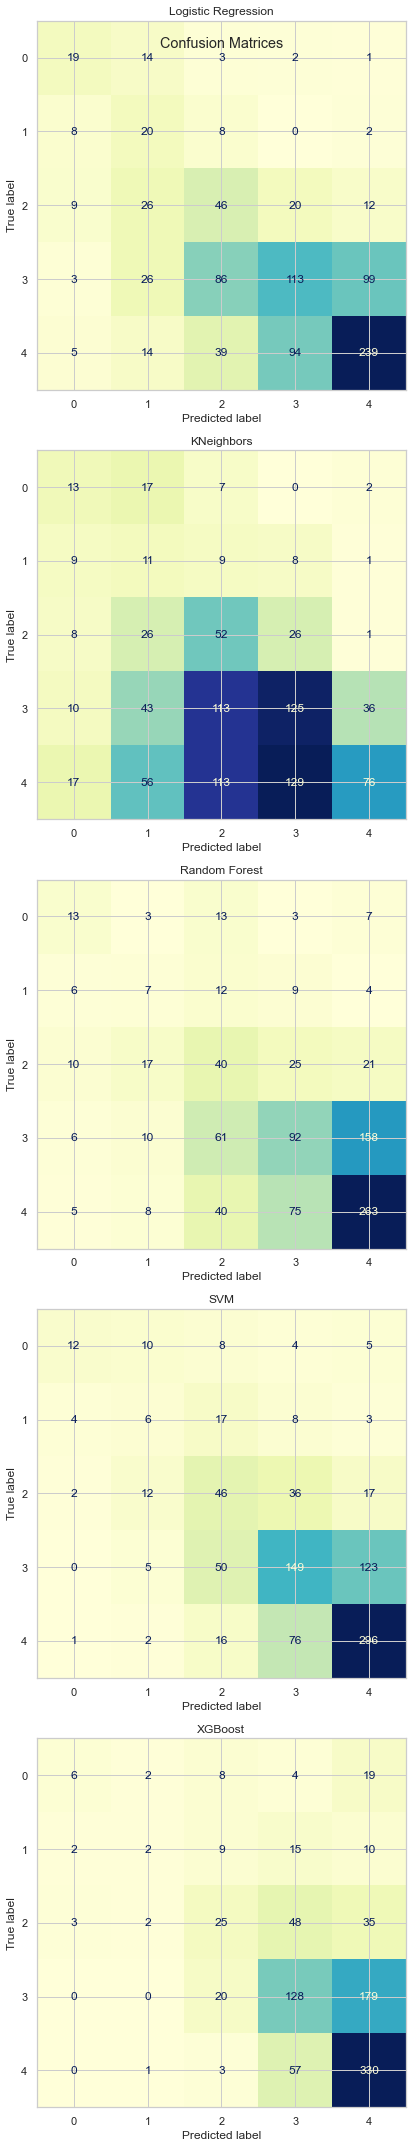

In [31]:
with warnings.catch_warnings(record=True):
    sentiment.visualize_classifiers()

The conclusions on the metrics can be visually verified by looking at confusion matrices produced by training and predicting each best model on a single random train-test split. As supposed the XGBoost classifier predicts very positively with almost all predictions being equal to or above 3 stars (Predicted label = 2 in the visualization). KNeighbors is obviously very bad and not even able to correctly predict the large chunk of 5 star reviews. As could be assumed through the evaluation metrics Logistic Regression looks the most like a diagonal, becoming a little bit less concise for the sparser regions of lower ratings.

Overall the experiments have shown that it is possible to train a machine learning model on review texts to predict a multiclass rating, but it takes careful selection of preprocessing steps and model architectures to achieve a at least usable predictive power. Enlarging the experiments could lead to achieving a better performance than found here. Admittedly though it seems like with the models tested here one cannot achieve top tier performance in predicting the yelp review rating.